# Delineate Basins

This tutorial demonstrates using PyWBT to delineate basins for a watershed in London. We use NASADEM to download the DEM data and delineate the basins using PyWBT.

In [1]:
from __future__ import annotations

from pathlib import Path

import pandas as pd

import pywbt

We use Microsoft Planetary Computer to access the [NASADEM](https://planetarycomputer.microsoft.com/dataset/nasadem) data. PyWBT has a modules called `dem_utils` that contains utiltiy functions for downloading and reading DEM data from 3DEP and/or NASADEM sources. Note that the module has some additional dependencies that need to be installed.

In [ ]:
fname = Path("data/dem_uk.tif")
fname.parent.mkdir(parents=True, exist_ok=True)
if not fname.exists():
    bbox = (0.0337, 51.5477, 0.1154, 51.6155)
    pywbt.dem_utils.get_nasadem(bbox, fname, to_utm=True)

For working with PyWBT, you need give the sequence of the WBT tools that you want to invoke with their respective parameters. We can a list of all the available WBT tools using `pywbt.list_tools()`. We can convert it into a `pandas.Series` to get a better view of the tools and query them based on the tool name or the tool description. For example, let's say we are looking for tools that resolve depressions in a DEM, we can query the tools based on the description to get the tool name.

In [3]:
tools = pd.Series(pywbt.list_tools())
tools[tools.str.contains("depression", case=False)]

BreachDepressions                    Breaches all of the depressions in a DEM using...
BreachDepressionsLeastCost           Breaches the depressions in a DEM using a leas...
DepthInSink                          Measures the depth of sinks (depressions) in a...
FillDepressions                      Fills all of the depressions in a DEM. Depress...
FillDepressionsPlanchonAndDarboux    Fills all of the depressions in a DEM using th...
FillDepressionsWangAndLiu            Fills all of the depressions in a DEM using th...
FlowAccumulationFullWorkflow         Resolves all of the depressions in a DEM, outp...
Sink                                 Identifies the depressions in a DEM, giving ea...
StochasticDepressionAnalysis         Performs a stochastic analysis of depressions ...
UpslopeDepressionStorage             Estimates the average upslope depression stora...
dtype: object

Let's say that we are interested in the `BreachDepressions` tool. We can get all the parameters required for the tool using `pywbt.tool_parameters('BreachDepressions')`. The output of this function is a list of dictionaries where each dictionary contains information for a parameter. Again, we can use `pandas.DataFrame` to get a better view of the parameters.

In [4]:
pd.DataFrame(pywbt.tool_parameters("BreachDepressions"))

,name,flags,description,parameter_type,default_value,optional
0,Input DEM File,"[-i, --dem]",Input raster DEM file.,{'ExistingFile': 'Raster'},None,False
1,Output File,"[-o, --output]",Output raster file.,{'NewFile': 'Raster'},None,False
2,Maximum Breach Depth (z units),[--max_depth],Optional maximum breach depth (default is Inf).,Float,None,True
3,Maximum Breach Channel Length (grid cells),[--max_length],Optional maximum breach channel length (in gri...,Float,None,True
4,Flat increment value (z units),[--flat_increment],Optional elevation increment applied to flat a...,Float,None,True
5,Fill single-cell pits?,[--fill_pits],Optional flag indicating whether to fill singl...,Boolean,false,True


In this example, we use the following sequence of tools:

1. `BreachDepressions`: An alternative to filling depressions in a DEM. This tool modifies the DEM to remove all depressions and flat areas, allowing water to flow off the edge of the DEM.
2. `D8Pointer`: A tool for generating flow pointer grid using the simple D8 algorithm.
3. `D8FlowAccumulation`: A tool for computing flow accumulation grid using the D8 algorithm.
4. `ExtractStreams`: A tool for extracting stream channels from a flow accumulation grid.
5. `FindMainStem`: A tool for finding the main stem of a stream network.
6. `StrahlerStreamOrder`: A tool for computing the Strahler stream order of a stream network.
7. `Basins`: A tool for automatic delineation of basins from a flow accumulation grid.

In [5]:
wbt_args = {
    "BreachDepressions": [f"-i={fname.name}", "--fill_pits", "-o=dem_corr.tif"],
    "D8Pointer": ["-i=dem_corr.tif", "-o=fdir.tif"],
    "D8FlowAccumulation": ["-i=fdir.tif", "--pntr", "-o=d8accum.tif"],
    "ExtractStreams": ["--flow_accum=d8accum.tif", "--threshold=600.0", "-o=streams.tif"],
    "RasterToVectorLines": ["-i=streams.tif", "-o=streams.shp"],
    "FindMainStem": ["--d8_pntr=fdir.tif", "--streams=d8accum.tif", "-o=mainstem.tif"],
    "StrahlerStreamOrder": [
        "--d8_pntr=fdir.tif",
        "--streams=streams.tif",
        "--zero_background",
        "-o=strahler.tif",
    ],
    "Basins": ["--d8_pntr=fdir.tif", "-o=basins.tif"],
}
save_dir = Path("results")
pywbt.whitebox_tools(
    fname.parent, wbt_args, ("streams.shp", "strahler.tif", "mainstem.tif", "basins.tif"), save_dir
)

We can take a look at the Strahler stream order and the basins delineated for the watershed.

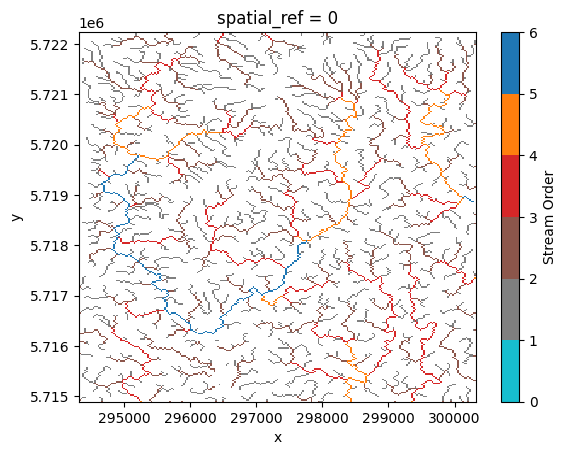

In [6]:
plot_dir = Path("images")
plot_dir.mkdir(parents=True, exist_ok=True)
stream_order = pywbt.dem_utils.tif_to_da(
    save_dir / "strahler.tif", "uint8", long_name="Stream Order", nodata=0
)
levels = range(stream_order.max().item() + 1)
ax = stream_order.where(stream_order > 0).plot.imshow(robust=False, levels=levels, cmap="tab10_r")
ax.figure.savefig(plot_dir / "stream_order.png", dpi=90)

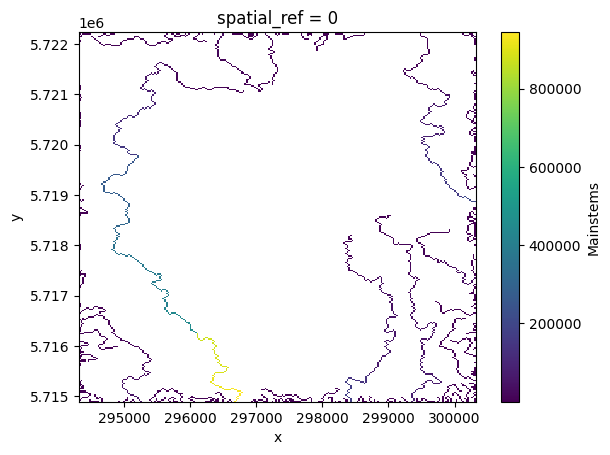

In [7]:
mainstem = pywbt.dem_utils.tif_to_da(f"{save_dir}/mainstem.tif", long_name="Mainstems")
_ = mainstem.where(mainstem > 0).plot.imshow()

In [8]:
basin_geo = pywbt.dem_utils.tif_to_gdf(f"{save_dir}/basins.tif", "int32", "basin")
basin_geo.loc[[basin_geo.area.idxmax()]].explore()